In [1]:
#@title SVHN
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

100%|██████████| 182040794/182040794 [00:20<00:00, 8849371.02it/s] 


100%|██████████| 64275384/64275384 [00:14<00:00, 4381943.17it/s] 


In [2]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

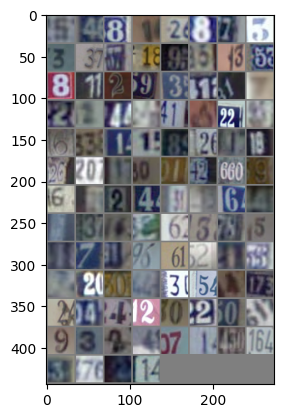

Labels: 5 4 8 1 2 8 7 3 3 3 7 1 9 5 1 5 8 1 2 9 3 1 1 7 2 2 4 4 1 3 2 5 6 3 1 1 8 2 1 8 6 0 1 0 1 2 6 9 6 2 2 4 3 1 6 4 5 3 4 5 6 3 8 5 1 7 1 6 6 2 1 3 7 2 0 4 3 5 4 7 2 4 4 2 0 2 0 1 9 3 2 4 7 1 3 6 3 7 2 1


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and labels
imshow(torchvision.utils.make_grid(images))
print("Labels:", " ".join(f"{labels[j].item()}" for j in range(batch_size)))

In [4]:
# Load a single batch from the data loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Print the shapes of images and labels
print("Images shape:", images.shape)  # Shape: (batch_size, num_channels, height, width)
print("Labels shape:", labels.shape)  # Shape: (batch_size,)

Images shape: torch.Size([100, 3, 32, 32])
Labels shape: torch.Size([100])


### Images

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)



# Show images
imshow(torchvision.utils.make_grid(images))

## title NCSNv2Deeper 


In [9]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch
from functools import partial
#from . import get_sigmas
from layers import *
from normalization import get_normalization

In [17]:
# title NCSNv2Deeper 

class NCSNv2Deeper(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.logit_transform = config.data.logit_transform
        self.rescaled = config.data.rescaled
        self.norm = get_normalization(config, conditional=False)
        self.ngf = ngf = config.model.ngf
        self.num_classes = config.model.num_classes
        self.act = act = get_act(config)
        #self.register_buffer('sigmas', get_sigmas(config))
        self.config = config
        

        self.begin_conv = nn.Conv2d(config.data.channels, ngf, 3, stride=1, padding=1)
        self.normalizer = self.norm(ngf, self.num_classes)

        self.end_conv = nn.Conv2d(ngf, config.data.channels, 3, stride=1, padding=1)

        self.res1 = nn.ModuleList([
            ResidualBlock(self.ngf, self.ngf, resample=None, act=act,
                          normalization=self.norm),
            ResidualBlock(self.ngf, self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res2 = nn.ModuleList([
            ResidualBlock(self.ngf, 2 * self.ngf, resample='down', act=act,
                          normalization=self.norm),
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res3 = nn.ModuleList([
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample='down', act=act,
                          normalization=self.norm),
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res4 = nn.ModuleList([
            ResidualBlock(2 * self.ngf, 4 * self.ngf, resample='down', act=act,
                          normalization=self.norm, dilation=2),
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample=None, act=act,
                          normalization=self.norm, dilation=2)]
        )

        self.res5 = nn.ModuleList([
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample='down', act=act,
                          normalization=self.norm, dilation=4),
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample=None, act=act,
                          normalization=self.norm, dilation=4)]
        )

        self.refine1 = RefineBlock([4 * self.ngf], 4 * self.ngf, act=act, start=True)
        self.refine2 = RefineBlock([4 * self.ngf, 4 * self.ngf], 2 * self.ngf, act=act)
        self.refine3 = RefineBlock([2 * self.ngf, 2 * self.ngf], 2 * self.ngf, act=act)
        self.refine4 = RefineBlock([2 * self.ngf, 2 * self.ngf], self.ngf, act=act)
        self.refine5 = RefineBlock([self.ngf, self.ngf], self.ngf, act=act, end=True)

    def _compute_cond_module(self, module, x):
        for m in module:
            x = m(x)
        return x

    def forward(self, x, y):
        if not self.logit_transform and not self.rescaled:
            h = 2 * x - 1.
        else:
            h = x

        output = self.begin_conv(h)

        layer1 = self._compute_cond_module(self.res1, output)
        layer2 = self._compute_cond_module(self.res2, layer1)
        layer3 = self._compute_cond_module(self.res3, layer2)
        layer4 = self._compute_cond_module(self.res4, layer3)
        layer5 = self._compute_cond_module(self.res5, layer4)

        ref1 = self.refine1([layer5], layer5.shape[2:])
        ref2 = self.refine2([layer4, ref1], layer4.shape[2:])
        ref3 = self.refine3([layer3, ref2], layer3.shape[2:])
        ref4 = self.refine4([layer2, ref3], layer2.shape[2:])
        output = self.refine5([layer1, ref4], layer1.shape[2:])

        output = self.normalizer(output)
        output = self.act(output)
        output = self.end_conv(output)

        used_sigmas = self.sigmas[y].view(x.shape[0], *([1] * len(x.shape[1:])))

        output = output / used_sigmas

        return output


### Class config

In [25]:
import yaml

# Load the YAML file as a dictionary
with open("configs.yml", "r") as file:
    config_dict = yaml.safe_load(file)

# Access the elements of the dictionary using dot notation
class Config:
    def __init__(self, d):
        self.training = Config.Training(d["training"])
        self.sampling = Config.Sampling(d["sampling"])
        self.fast_fid = Config.FastFID(d["fast_fid"])
        self.test = Config.Test(d["test"])
        self.data = Config.Data(d["data"])
        self.model = Config.Model(d["model"])
        self.optim = Config.Optim(d["optim"])
    class Training:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.n_epochs = d["n_epochs"]
            self.n_iters = d["n_iters"]
            self.snapshot_freq = d["snapshot_freq"]
            self.snapshot_sampling = d["snapshot_sampling"]
            self.anneal_power = d["anneal_power"]
            self.log_all_sigmas = d["log_all_sigmas"]

    class Sampling:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.data_init = d["data_init"]
            self.step_lr = d["step_lr"]
            self.n_steps_each = d["n_steps_each"]
            self.ckpt_id = d["ckpt_id"]
            self.final_only = d["final_only"]
            self.fid = d["fid"]
            self.denoise = d["denoise"]
            self.num_samples4fid = d["num_samples4fid"]
            self.inpainting = d["inpainting"]
            self.interpolation = d["interpolation"]
            self.n_interpolations = d["n_interpolations"]

    class FastFID:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.num_samples = d["num_samples"]
            self.step_lr = d["step_lr"]
            self.n_steps_each = d["n_steps_each"]
            self.begin_ckpt = d["begin_ckpt"]
            self.end_ckpt = d["end_ckpt"]
            self.verbose = d["verbose"]
            self.ensemble = d["ensemble"]

    class Test:
        def __init__(self, d):
            self.begin_ckpt = d["begin_ckpt"]
            self.end_ckpt = d["end_ckpt"]
            self.batch_size = d["batch_size"]

    class Data:
        def __init__(self, d):
            self.dataset = d["dataset"]
            self.image_size = d["image_size"]
            self.channels = d["channels"]
            self.logit_transform = d["logit_transform"]
            self.uniform_dequantization = d["uniform_dequantization"]
            self.gaussian_dequantization = d["gaussian_dequantization"]
            self.random_flip = d["random_flip"]
            self.rescaled = d["rescaled"]
            self.num_workers = d["num_workers"]

    class Model:
        def __init__(self, d):
            self.sigma_begin = d["sigma_begin"]
            self.num_classes = d["num_classes"]
            self.ema = d["ema"]
            self.ema_rate = d["ema_rate"]
            self.spec_norm = d["spec_norm"]
            self.sigma_dist = d["sigma_dist"]
            self.sigma_end = d["sigma_end"]
            self.normalization = d["normalization"]
            self.nonlinearity = d["nonlinearity"]
            self.ngf = d["ngf"]

    class Optim:
        def __init__(self, d):
            self.weight_decay = d["weight_decay"]
            self.optimizer = d["optimizer"]
            self.lr = d["lr"]
            self.beta1 = d["beta1"]
            self.amsgrad = d["amsgrad"]
            self.eps = d["eps"]

    


# Create a config object
config = Config(config_dict)




In [26]:

model = NCSNv2Deeper(config)

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")



Number of trainable parameters: 83445379


### title Defining a time-dependent score-based model

In [29]:
### title Defining a time-dependent score-based model

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, padding=1, bias=False) # 3 , padding=1
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, padding=1, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, padding=1, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, padding=1, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, padding=1,  bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, padding=1,  output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 3, 3, stride=1, padding=1) # 3
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# Instantiate the model with example marginal_prob_std function
marginal_prob_std = lambda t: torch.ones(t.shape[0])
model = ScoreNet(marginal_prob_std)

# Calculate the number of trainable parameters
num_trainable_params = count_parameters(model)
print("Number of trainable parameters:", num_trainable_params)

Number of trainable parameters: 1117027


### title Set up the SDE

In [31]:
#@title Set up the SDE
import functools

from functools import partial, reduce


device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  10.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

### Loss        

In [ ]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss